In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [86]:
path = "data/mnist/"

In [87]:
import os
os.makedirs(path, exist_ok=True)

In [88]:
FILENAME='mnist.pkl.gz'

In [89]:
def load_mnist(filename):
    return pickle.load(gzip.open(filename,'rb') , encoding="latin_1")

In [132]:
((x,y) , (x_valid , y_valid), _) = load_mnist(path + FILENAME)

In [8]:
type(x) , x.shape , type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

In [133]:
mean = x.mean()
std = x.std()

In [134]:
x = (x - mean)/std

In [135]:
x_valid = (x_valid - mean)/std

In [136]:
x_valid.mean() , x_valid.std()

(-0.005850922, 0.99243325)

## plots

In [15]:
x_valid.shape

(10000, 784)

In [16]:
x_imgs = np.reshape(x_valid , (-1,28,28)) ; x_imgs

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

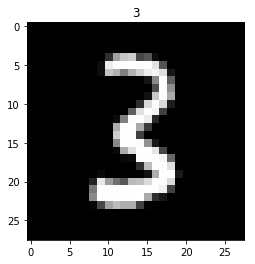

In [18]:
show(x_imgs[0],y_valid[0])

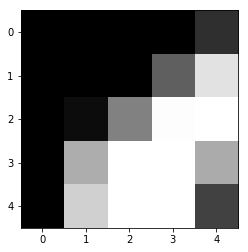

In [19]:
show(x_imgs[0,10:15,10:15])

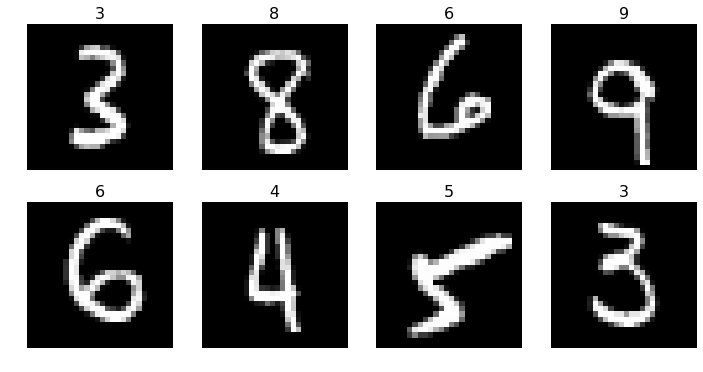

In [20]:
plots(x_imgs[:8] , titles=y_valid[0:8])

In [137]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [142]:
net = nn.Sequential(
    nn.Linear(28*28 , 10),
    nn.LogSoftmax()
)

In [143]:
# num of parameters 
t= [o.numel() for o in net.parameters()]
t , sum(t)

([7840, 10], 7850)

In [144]:
md = ImageClassifierData.from_arrays(path , (x,y) , (x_valid , y_valid))

In [145]:
loss = nn.NLLLoss() # negetive log liklihood loss (cross entropy)
metrics = [accuracy]
opt = optim.Adam(net.parameters())

In [146]:
fit(net , md , n_epochs = 1 , crit = loss , opt = opt , metrics = metrics)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.32842    0.288917   0.9187    



[array([0.28892]), 0.9187]

In [26]:
def binary_loss(y , p):
    return np.mean(-((1-y)*np.log(1-p) + y*np.log(p)))

In [25]:
acts = np.array([1,0,0,1])
preds = np.array([0.9 , 0.1 , 0.2 , 0.8])
binary_loss(acts , preds)

0.164252033486018

In [26]:
preds = predict(net , md.val_dl)

In [27]:
preds.shape

(10000, 10)

In [28]:
type(preds)

numpy.ndarray

In [29]:
preds = preds.argmax(axis = 1)

In [30]:
preds[:4]

array([3, 8, 6, 9], dtype=int64)

In [31]:
y_valid[:4]

array([3, 8, 6, 9], dtype=int64)

In [32]:
np.mean(preds == y_valid)

0.9176

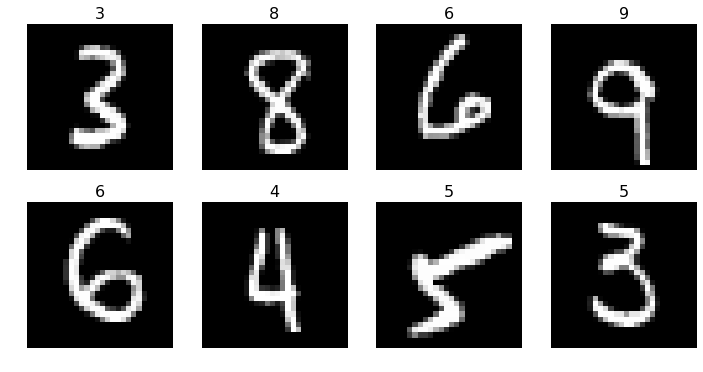

In [33]:
plots(x_imgs[:8] , titles= preds[:8])

In [9]:
def get_weights(*dims) :
    return(nn.Parameter(torch.randn(dims)/dims[0]))

In [27]:
class Log_reg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28 , 10)
        self.l1_b = get_weights(10)
    def forward(self,x):
        x = x.view(x.size(0) , -1)
        x = torch.matmul(x,self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None]))
        return x

In [28]:
net2 = Log_reg()
opt = optim.Adam(net2.parameters())

In [29]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.379916   0.33558    0.912     



[array([0.33558]), 0.912]

In [30]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

In [31]:
net2 = LogReg()
opt = optim.Adam(net2.parameters())

In [40]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.319978   0.280961   0.9205    



[array([0.28096]), 0.9205]

In [41]:
#why these two above accuracies are different ?

In [42]:
# *dims in python ? 
#>>  "https://docs.python.org/3/tutorial/controlflow.html"  
# >>4.7.3. Arbitrary Argument Lists

In [43]:
dl = iter(md.trn_dl)
xmb , ymb = next(dl)

In [44]:
xmb


-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.FloatTensor of size 64x784]

In [45]:
vxmb = Variable(xmb)
vxmb

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.FloatTensor of size 64x784]

In [46]:
preds = net2(vxmb).exp()
preds

Variable containing:

Columns 0 to 5 
 7.9484e-05  2.7247e-06  1.8865e-04  3.0492e-05  4.3168e-02  3.1944e-05
 3.2622e-05  2.3799e-07  9.7357e-01  1.1084e-04  7.6797e-03  3.5950e-07
 1.5033e-04  1.9721e-01  1.8761e-02  7.7864e-03  1.8234e-05  6.8594e-01
 5.3534e-06  1.7476e-02  6.1145e-01  2.9612e-01  1.6646e-08  2.0943e-03
 7.3868e-01  2.8535e-04  1.1428e-02  8.2286e-02  1.7366e-05  1.2064e-01
 5.4128e-06  7.1171e-05  8.5061e-04  1.5627e-03  7.8295e-01  2.7256e-03
 2.4234e-02  8.2671e-05  9.2198e-04  1.3663e-05  3.9631e-04  6.6465e-01
 1.0000e+00  2.3751e-15  2.1385e-10  1.9387e-08  5.8860e-12  3.9866e-06
 1.6582e-06  1.3427e-09  1.0520e-06  2.4604e-08  9.9880e-01  2.7451e-05
 3.6728e-07  1.9036e-02  6.5421e-01  1.9580e-03  4.1500e-05  1.1751e-04
 1.9875e-03  2.0072e-03  1.5567e-02  9.4665e-01  2.7132e-06  2.1895e-02
 1.4493e-05  1.1136e-10  2.9190e-09  3.9685e-06  8.8639e-07  5.8802e-05
 1.4533e-04  7.3884e-07  9.8849e-06  1.7591e-07  8.1513e-01  3.8204e-03
 1.7331e-06  1.4808e-03  9

In [47]:
preds.max(1)[1]

Variable containing:
 9
 2
 5
 2
 0
 4
 5
 0
 4
 2
 3
 7
 4
 2
 8
 6
 7
 5
 1
 8
 6
 0
 8
 9
 8
 3
 6
 8
 1
 6
 7
 6
 4
 8
 0
 0
 9
 8
 1
 4
 9
 9
 9
 0
 1
 1
 6
 1
 8
 4
 1
 2
 7
 9
 4
 4
 8
 3
 4
 3
 8
 1
 4
 3
[torch.LongTensor of size 64]

In [157]:
net3 = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)

In [163]:
t = [o.numel() for o in net3.parameters()]
t, sum(t)

([78400, 100, 10000, 100, 1000, 10], 89610)

## because net3 has so many Parameters (89610 near 100'000) it is prone to overfitting so we should use regularization 

In [158]:
md = ImageClassifierData.from_arrays(path , (x,y) , (x_valid , y_valid))

In [159]:
loss=nn.NLLLoss()
metrics=[accuracy]
#opt=optim.Adam(net3.parameters(), 1e-2)
opt=optim.SGD(net3.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [160]:
set_lrs(opt,1e-2) # decay lr when it is gonna converge 

In [161]:
fit(net3, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.175525   0.15375    0.9558    
    1      0.128496   0.117455   0.9667                                                                                
    2      0.101498   0.094676   0.9721                                                                                
    3      0.081121   0.093412   0.9713                                                                                
    4      0.065103   0.084829   0.9748                                                                                



[array([0.08483]), 0.9748]

# element wise operations in pytorch 

In [52]:
a = np.array([10,6,-4])
b = np.array([2,8,7])

a,b

(array([10,  6, -4]), array([2, 8, 7]))

In [53]:
a + b

array([12, 14,  3])

In [54]:
a = T([10,6,-4])
b = T([2,8,7])

a,b

(
  10
   6
  -4
 [torch.LongTensor of size 3], 
  2
  8
  7
 [torch.LongTensor of size 3])

In [55]:
a + b


 12
 14
  3
[torch.LongTensor of size 3]

In [56]:
a < b


 0
 1
 1
[torch.ByteTensor of size 3]

In [3]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [4]:
c = np.array([10,20,30]); c , c.shape

(array([10, 20, 30]), (3,))

In [86]:
c + m

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [8]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [5]:
c = np.array([[10,20,30]]); c

array([[10, 20, 30]])

In [6]:
c.shape

(1, 3)

In [7]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [60]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [61]:
c = c.reshape((3,1))

In [62]:
m + c

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [63]:
c = np.array([10,20,30]); c.shape

(3,)

In [64]:
c[None].shape

(1, 3)

In [65]:
c[:,None].shape

(3, 1)

In [66]:
c[None,:,None].shape

(1, 3, 1)

In [67]:
# don't confuse usage of  -1 and None

In [68]:
c.shape

(3,)

In [69]:
np.broadcast_to(c,(3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [70]:
np.broadcast_to(c,m.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [71]:
c[None] * c[:,None]  # it is not matmul

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

In [72]:
m , c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [73]:
m @ c

array([140, 320, 500])

In [74]:
T(m) @ T(c)


 140
 320
 500
[torch.LongTensor of size 3]

In [76]:
c.shape , m.shape

((3,), (3, 3))

In [77]:
T(m) @ T(c[None]) # Error

RuntimeError: size mismatch, m1: [3 x 3], m2: [1 x 3] at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\th\generic/THTensorMath.c:1434

In [78]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [79]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [83]:
n[: , 0]  ,  n[: , 0].shape

(array([10, 20, 30]), (3,))

In [87]:
(m*n[:,0]).sum(1)

array([140, 320, 500])

In [97]:
Q = (m*n[:,1]).sum(1) ; Q , Q.shape

(array([ 25, 130, 235]), (3,))

In [90]:
m @ n

array([[140,  25],
       [320, 130],
       [500, 235]])

# lets write the code for fit

In [32]:
dl = iter(md.trn_dl)

In [33]:
net2 = LogReg()
loss = nn.NLLLoss()
learning_rate = 1e-3
optimizer = optim.Adam(net2.parameters(),lr=learning_rate)

In [34]:
xt , yt = next(dl)
y_pred = net2(Variable(xt))

In [35]:
l = loss(y_pred , Variable(yt))
print(l)

# at first i forgot initilizing net2 again and my loss was much smaller

Variable containing:
 2.3099
[torch.FloatTensor of size 1]



In [36]:
optimizer.zero_grad()
l.backward()
optimizer.step()

In [37]:
y_pred = net2(Variable(xt))
l = loss(y_pred , Variable(yt))
print(l)

Variable containing:
 2.2464
[torch.FloatTensor of size 1]



In [38]:
xt , yt = next(dl)
y_pred = net2(Variable(xt))

In [39]:
l = loss(y_pred , Variable(yt))
print(l)

Variable containing:
 2.2507
[torch.FloatTensor of size 1]



In [40]:
for t in range(100):
    xt,yt = next(dl)
    y_pred = net2(Variable(xt))
    l = loss(y_pred,Variable(yt))
    
    if t % 10 == 0:
        accuracy = np.mean( to_np(y_pred).argmax(1) == to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)
    
    optimizer.zero_grad() # remove gradients of previous step , 
                          #it exist because you can have several loss func 
    l.backward()
    optimizer.step()

loss:  2.2322325706481934 	 accuracy:  0.484375
loss:  1.9570125341415405 	 accuracy:  0.578125
loss:  1.6760571002960205 	 accuracy:  0.75
loss:  1.3999433517456055 	 accuracy:  0.78125
loss:  1.2230123281478882 	 accuracy:  0.78125
loss:  1.1877285242080688 	 accuracy:  0.78125
loss:  1.1064789295196533 	 accuracy:  0.78125
loss:  0.9942381381988525 	 accuracy:  0.796875
loss:  0.9403474926948547 	 accuracy:  0.828125
loss:  0.9169701337814331 	 accuracy:  0.859375


In [45]:
def score(x,y):
    y_pred = to_np(net2(Variable(x)))
    return np.mean(y_pred.argmax(axis = 1) == to_np(y))

In [50]:
net2 = LogReg()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in dl : #range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*i) for i in val_dl] #range(len(val_dl))
    print(np.mean(val_scores))

0.8532046178343949


In [59]:
val_scores

[0.859375,
 0.828125,
 0.84375,
 0.828125,
 0.890625,
 0.765625,
 0.71875,
 0.890625,
 0.734375,
 0.765625,
 0.796875,
 0.796875,
 0.78125,
 0.78125,
 0.875,
 0.9375,
 0.875,
 0.8125,
 0.828125,
 0.765625,
 0.796875,
 0.8125,
 0.84375,
 0.859375,
 0.9375,
 0.875,
 0.875,
 0.875,
 0.8125,
 0.90625,
 0.875,
 0.84375,
 0.734375,
 0.65625,
 0.78125,
 0.828125,
 0.84375,
 0.84375,
 0.84375,
 0.890625,
 0.9375,
 0.8125,
 0.765625,
 0.703125,
 0.859375,
 0.75,
 0.828125,
 0.78125,
 0.875,
 0.796875,
 0.84375,
 0.828125,
 0.921875,
 0.921875,
 0.765625,
 0.734375,
 0.84375,
 0.875,
 0.859375,
 0.875,
 0.78125,
 0.8125,
 0.8125,
 0.796875,
 0.875,
 0.84375,
 0.875,
 0.9375,
 0.828125,
 0.78125,
 0.828125,
 0.796875,
 0.90625,
 0.921875,
 0.84375,
 0.875,
 0.765625,
 0.734375,
 0.84375,
 0.890625,
 0.921875,
 0.859375,
 0.859375,
 0.875,
 0.859375,
 0.875,
 0.90625,
 0.84375,
 0.890625,
 0.859375,
 0.8125,
 0.859375,
 0.9375,
 0.890625,
 0.890625,
 0.875,
 0.875,
 0.828125,
 0.875,
 0.8125,
 0.9

In [62]:
net2 = LogReg()
loss=nn.NLLLoss()
lr = 1e-2
#optimizer=optim.SGD(net2.parameters(), lr=learning_rate)
w , b = net2.l1_w , net2.l1_b

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in dl : #range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        #optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*i) for i in val_dl] #range(len(val_dl))
    print(np.mean(val_scores))

0.8540007961783439
